# all flight partners PTE email to PTE+AOP offers conversion prediction

In [4]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [5]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [6]:
query="""
SELECT * FROM ml_prep.gauthier_all_flights_pte_aop_email_to_offer where email_sent_date_in_segment_1_origin_tz >= '2019-10-20 00:00:00' AND email_sent_date_in_segment_1_origin_tz < '2019-11-07 00:00:00'  ;
"""
df = pd.read_sql_query(query, con)
df.head(10)


email_sent_date_in_segment_1_origin_tz     pnr  partner_id point_of_sale  \
0                2019-10-29 10:03:41.458  1APDMJ          26            CH   
1                2019-11-02 13:17:03.365  222N42           9            US   
2                2019-11-02 11:34:45.315  222PAW           9            US   
3                2019-11-02 16:46:49.860  2237TW           9            US   
4                2019-10-20 11:07:23.523  22455W           9            US   
5                2019-11-05 05:14:42.572  224MY2           9            IE   
6                2019-10-27 11:27:03.452  226AHB           9            IE   
7                2019-11-03 10:30:53.445  226J6J           9            US   
8                2019-10-27 12:48:57.657  226LEJ           9            IE   
9                2019-11-03 17:46:46.560  226ZRS           9            IE   

  language  loyalty_level  passenger_count         email_sent_date  \
0       en              0                2 2019-10-29 00:03:41.458   
1       EN              0                1 2019-11-02 18:17:03.365   
2       EN              0                2 2019-11-02 18:34:45.315   
3       EN              0                1 2019-11-02 21:46:49.860   
4       EN              0                1 2019-10-20 16:07:23.523   
5       EN              0                1 2019-11-05 10:14:42.572   
6       EN              0                1 2019-10-27 11:27:03.452   
7       EN              0                3 2019-11-03 15:30:53.445   
8       NL              0                1 2019-10-27 12:48:57.657   
9       EN              0                2 2019-11-03 17:46:46.560   

  segment_1_origination segment_1_destination  ...  \
0                   BNE                   SYD  ...   
1                   ORD                   DUB  ...   
2                   LAX                   DUB  ...   
3                   ORD                   DUB  ...   
4                   ORD                   DUB  ...   
5                   IAD                   DUB  ...   
6                   SNN                   BOS  ...   
7                   JFK                   DUB  ...   
8                   DUB                   JFK  ...   
9                   DUB                   MCO  ...   

  segment_4_booked_fare_class segment_4_upgrade_cabin  \
0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
8                                                       
9                                                       

   segment_4_flight_number segment_4_carrier_code  \
0                      NaN                          
1                      NaN                          
2                      NaN                          
3                      NaN                          
4                      NaN                          
5                      NaN                          
6                      NaN                          
7                      NaN                          
8                      NaN                          
9                      NaN                          

  segment_4_departure_local_date_time total_amount_itinerary_usd  \
0                                                            NaN   
1                                                            NaN   
2                                                            NaN   
3                                                            NaN   
4                                                            NaN   
5                                                            NaN   
6                                                            NaN   
7                    

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706878 entries, 0 to 1706877
Data columns (total 41 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   email_sent_date_in_segment_1_origin_tz  datetime64[ns]
 1   pnr                                     object        
 2   partner_id                              int64         
 3   point_of_sale                           object        
 4   language                                object        
 5   loyalty_level                           int64         
 6   passenger_count                         int64         
 7   email_sent_date                         datetime64[ns]
 8   segment_1_origination                   object        
 9   segment_1_destination                   object        
 10  segment_1_booked_fare_class             object        
 11  segment_1_upgrade_cabin                 object        
 12  segment_1_flight_number                 in

# Feature Engineering

In [8]:
# compute some time-related features
# this takes some time

#df['email_sent_date'] = df['email_sent_date_in_segment_1_origin_tz']

# email sent time
df['email_sent_day_of_week']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.dayofweek)
df['email_sent_hour']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.hour)
df['email_sent_month']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.month)
df['email_sent_year']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.year)
df["email_sent_days_before_departure"] =(pd.to_datetime(df["segment_1_departure_local_date_time"])-pd.to_datetime(df["email_sent_date"]).dt.tz_localize(None)).apply(lambda x: x.days)


In [9]:
# segment 1 
df['segment_1_departure_hour'] = pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_1_departure_day_of_week']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_1_departure_month']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_1_origin_destination'] = df['segment_1_origination']+ df['segment_1_destination']

# segment 2
df['segment_2_departure_hour'] = pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_2_departure_day_of_week']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_2_departure_month']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_2_origin_destination'] = df['segment_2_origination']+ df['segment_2_destination']

# segment 3
df['segment_3_departure_hour'] = pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_3_departure_day_of_week']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_3_departure_month']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_3_origin_destination'] = df['segment_3_origination']+ df['segment_3_destination']

# segment 4
df['segment_4_departure_hour'] = pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_4_departure_day_of_week']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_4_departure_month']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_4_origin_destination'] = df['segment_4_origination']+ df['segment_4_destination']

df['passenger_count'] = df['passenger_count'].fillna(0).astype(int)


In [10]:
df[:3]

email_sent_date_in_segment_1_origin_tz     pnr  partner_id point_of_sale  \
0                2019-10-29 10:03:41.458  1APDMJ          26            CH   
1                2019-11-02 13:17:03.365  222N42           9            US   
2                2019-11-02 11:34:45.315  222PAW           9            US   

  language  loyalty_level  passenger_count         email_sent_date  \
0       en              0                2 2019-10-29 00:03:41.458   
1       EN              0                1 2019-11-02 18:17:03.365   
2       EN              0                2 2019-11-02 18:34:45.315   

  segment_1_origination segment_1_destination  ... segment_2_departure_month  \
0                   BNE                   SYD  ...                         0   
1                   ORD                   DUB  ...                        12   
2                   LAX                   DUB  ...                         6   

  segment_2_origin_destination  segment_3_departure_hour  \
0                                                      0   
1                       DUBORD                         0   
2                       DUBLAX                         0   

  segment_3_departure_day_of_week segment_3_departure_month  \
0                               0                         0   
1                               0                         0   
2                               0                         0   

  segment_3_origin_destination segment_4_departure_hour  \
0                                                     0   
1                                                     0   
2                                                     0   

  segment_4_departure_day_of_week segment_4_departure_month  \
0                               0                         0   
1                               0                         0   
2                               0                         0   

   segment_4_origin_destination  
0                                
1                                
2                                

[3 rows x 62 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706878 entries, 0 to 1706877
Data columns (total 62 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   email_sent_date_in_segment_1_origin_tz  datetime64[ns]
 1   pnr                                     object        
 2   partner_id                              int64         
 3   point_of_sale                           object        
 4   language                                object        
 5   loyalty_level                           int64         
 6   passenger_count                         int64         
 7   email_sent_date                         datetime64[ns]
 8   segment_1_origination                   object        
 9   segment_1_destination                   object        
 10  segment_1_booked_fare_class             object        
 11  segment_1_upgrade_cabin                 object        
 12  segment_1_flight_number                 in

# Feature Encoding

In [12]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [13]:
# label-encode categories
# there is no channel source since it's always PTE.
columns = ['language','point_of_sale'] + \
['segment_1_origination','segment_1_destination','segment_1_origin_destination','segment_1_booked_fare_class','segment_1_upgrade_cabin']+ \
['segment_2_origination','segment_2_destination','segment_2_origin_destination','segment_2_booked_fare_class','segment_2_upgrade_cabin'] + \
['segment_3_origination','segment_3_destination','segment_3_origin_destination','segment_3_booked_fare_class','segment_3_upgrade_cabin'] + \
['segment_4_origination','segment_4_destination','segment_4_origin_destination','segment_4_booked_fare_class','segment_4_upgrade_cabin'] 

df= label_encode_categorical(df,columns)


label encoding language ...
label encoding point_of_sale ...
label encoding segment_1_origination ...
label encoding segment_1_destination ...
label encoding segment_1_origin_destination ...
label encoding segment_1_booked_fare_class ...
label encoding segment_1_upgrade_cabin ...
label encoding segment_2_origination ...
label encoding segment_2_destination ...
label encoding segment_2_origin_destination ...
label encoding segment_2_booked_fare_class ...
label encoding segment_2_upgrade_cabin ...
label encoding segment_3_origination ...
label encoding segment_3_destination ...
label encoding segment_3_origin_destination ...
label encoding segment_3_booked_fare_class ...
label encoding segment_3_upgrade_cabin ...
label encoding segment_4_origination ...
label encoding segment_4_destination ...
label encoding segment_4_origin_destination ...
label encoding segment_4_booked_fare_class ...
label encoding segment_4_upgrade_cabin ...


In [14]:
columns_for_training= [    
                        # segment 1
                        'segment_1_origination_encoded',
                        'segment_1_destination_encoded',
                        'segment_1_origin_destination_encoded',
                        'segment_1_booked_fare_class_encoded',
                        'segment_1_upgrade_cabin_encoded',
    
                         # segment 2
                        'segment_2_origination_encoded',
                        'segment_2_destination_encoded',
                        'segment_2_origin_destination_encoded',
                        'segment_2_booked_fare_class_encoded',
                        'segment_2_upgrade_cabin_encoded',

                         # segment 3
                        'segment_3_origination_encoded',
                        'segment_3_destination_encoded',
                        'segment_3_origin_destination_encoded',
                        'segment_3_booked_fare_class_encoded',
                        'segment_3_upgrade_cabin_encoded',

                         # segment 4
                        'segment_4_origination_encoded',
                        'segment_4_destination_encoded',
                        'segment_4_origin_destination_encoded',
                        'segment_4_booked_fare_class_encoded',
                        'segment_4_upgrade_cabin_encoded',
    
                        # email
                        'email_sent_day_of_week',
                        'email_sent_hour',
                        'email_sent_month',
                        'email_sent_year',
                        'email_sent_days_before_departure',
    
                        # 
                        'partner_id',
    
                       # the rest
                       'language_encoded',
                       'passenger_count',
                       'point_of_sale_encoded',

                       # target
                        'has_offer',
                      ]

df = df[columns_for_training]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706878 entries, 0 to 1706877
Data columns (total 30 columns):
 #   Column                                Dtype
---  ------                                -----
 0   segment_1_origination_encoded         int64
 1   segment_1_destination_encoded         int64
 2   segment_1_origin_destination_encoded  int64
 3   segment_1_booked_fare_class_encoded   int64
 4   segment_1_upgrade_cabin_encoded       int64
 5   segment_2_origination_encoded         int64
 6   segment_2_destination_encoded         int64
 7   segment_2_origin_destination_encoded  int64
 8   segment_2_booked_fare_class_encoded   int64
 9   segment_2_upgrade_cabin_encoded       int64
 10  segment_3_origination_encoded         int64
 11  segment_3_destination_encoded         int64
 12  segment_3_origin_destination_encoded  int64
 13  segment_3_booked_fare_class_encoded   int64
 14  segment_3_upgrade_cabin_encoded       int64
 15  segment_4_origination_encoded         int64
 16  

In [16]:
df.head(4)

segment_1_origination_encoded  segment_1_destination_encoded  \
0                             70                            591   
1                            450                            172   
2                            327                            172   
3                            450                            172   

   segment_1_origin_destination_encoded  segment_1_booked_fare_class_encoded  \
0                                   707                                   34   
1                                  3445                                   31   
2                                  2398                                   31   
3                                  3445                                    0   

   segment_1_upgrade_cabin_encoded  segment_2_origination_encoded  \
0                                2                              0   
1                                2                            173   
2                                2                            173   
3                                2                            173   

   segment_2_destination_encoded  segment_2_origin_destination_encoded  \
0                              0                                     0   
1                            452                                  1346   
2                            327                                  1340   
3                            452                                  1346   

   segment_2_booked_fare_class_encoded  segment_2_upgrade_cabin_encoded  ...  \
0                                    0                                0  ...   
1                                    1                                3  ...   
2                                   31                                3  ...   
3                                    1                                3  ...   

   email_sent_day_of_week  email_sent_hour  email_sent_month  email_sent_year  \
0                       1                0                10             2019   
1                       5               18                11             2019   
2                       5               18                11             2019   
3                       5               21                11             2019   

   email_sent_days_before_departure  partner_id  language_encoded  \
0                                71          26                18   
1                                12           9                 1   
2                               201           9                 1   
3                                70           9                 1   

   passenger_count  point_of_sale_encoded  has_offer  
0                2                     26      False  
1                1                    152      False  
2                2                    152      False  
3                1                    152      False  

[4 rows x 30 columns]

In [17]:
# we could use month to split train/test data
pd.DataFrame.hist(df,column='email_sent_year')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2d61c0400>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2d2b1d940>]],
      dtype=object)

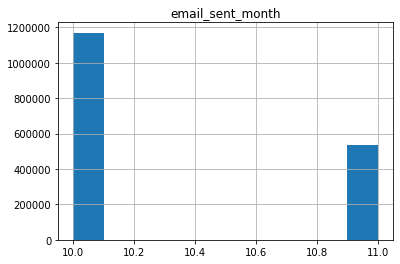

In [18]:
# we could use month to split train/test data
pd.DataFrame.hist(df,column='email_sent_month')

# Model Training & Evaluation

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, title=None):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title is not None:
        plt.title(title)
    plt.show()
        

In [20]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False, by_partner=False, sim=False):
    # X-validation
    import warnings
    from sklearn.exceptions import UndefinedMetricWarning
    warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest = RandomForestClassifier(n_estimators=100)
    X = df_to_train.drop("has_offer", axis=1)
    y = df_to_train["has_offer"]
    
    if split_on_time:
        X_train = X[X["email_sent_month"] == 10 ].drop("email_sent_month", axis=1)
        y_train = y[X["email_sent_month"] == 10]
        X_test = X[X["email_sent_month"] == 11].drop("email_sent_month", axis=1)
        y_test = y[X["email_sent_month"] == 11]
        print('split on time')
    else:
        X = X.drop("email_sent_month", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    print('training on', str(len(X_train)), 'rows...')
    print('testing on', str(len(X_test)), 'rows...')

    random_forest.fit(X_train, y_train)
    print('training is done!')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)[:,1]
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10,7))
    plt.title('ROC')
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr,marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = metrics.auc(fpr, tpr)

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(10,7))
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # proportion of positive examples
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(recalls, precisions, marker='.')    

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    print('precision', precision[1])
    print('recall', recall[1])
    print('f1', f1[1])
    print('support', support[1])

    cm = metrics.confusion_matrix(y_test, y_test_predict)
    print_confusion_matrix(cm, ['no bid','bid'])
    print('roc auc', auc)
    
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    for feature,importance in zip(features[indices],importances[indices]):
        print(feature+','+str(importance))
    plt.show()

    if sim:
        print('Running simulation on test set')
        total_email_sent = len(y_test)
        print(total_email_sent, 'email sent')
        print(len(y_test[y_test==1]), 'actual number of offers')
        ratio = len(y_test[y_test==1]) / total_email_sent
        print('conversion ratio',ratio)
        threshold=0.5
        predicted_positive = len(y_test_proba[y_test_proba > threshold])
        print('predicted_positive',predicted_positive,'with threshold',threshold)
        total_current_proba = y_test_proba.sum()
        total_max_proba = 0
        best_sent_hours_for_all=[]
        original_sent_hours_for_all=[]

        all_dfs=[]
        for email_sent_hour in range(0,24):
            #min_index = email_sent_hour * total_email_sent
            #max_index = (email_sent_hour +1) * total_email_sent
            #print('email_sent_hour',email_sent_hour,'min_index',min_index,'max_index',max_index)
            #X_test_repeated.iloc[min_index:max_index]['email_sent_date'] = email_sent_hour
            df_for_hour = X_test.copy()
            df_for_hour['email_sent_hour'] = email_sent_hour
            all_dfs.append(df_for_hour)
            
        X_test_repeated=pd.concat(all_dfs,ignore_index=True)
        print('size of new test set',X_test_repeated.shape[0])
        proba_repeated = random_forest.predict_proba(X_test_repeated)[:,1]
        
        mod = int(X_test.shape[0] / 20)
        
        best_proba_by_partner = {}
        
        for index in range(total_email_sent):
            indexes = []
            for email_sent_hour in range(0,24):
                indexes.append( email_sent_hour * total_email_sent + index)
            
            probas_for_index = proba_repeated[indexes]
            original_email_sent_hour = X_test.iloc[index]['email_sent_hour']
            original_proba = y_test_proba[index]
            
            max_proba = max(probas_for_index)
            
            best_email_sent_hour = np.argmax(probas_for_index)
            
            if max_proba==original_proba:
                best_email_sent_hour=original_email_sent_hour
            
            if index % mod == 0 :
                print('Row',index,'raw_email_sent_hour',original_email_sent_hour,
                         'raw_proba',original_proba,'best_email_sent_hour',best_email_sent_hour,'best_proba',max_proba)
                #print(probas_for_index)
            
            best_sent_hours_for_all.append(best_email_sent_hour)
            original_sent_hours_for_all.append(original_email_sent_hour)
            
            new_sum_for_partner = best_proba_by_partner.get(X_test.iloc[index]['partner_id'], 0) + max_proba
            best_proba_by_partner[X_test.iloc[index]['partner_id']] = new_sum_for_partner
            
            total_max_proba = total_max_proba + max_proba
            
        print('total_current_proba',total_current_proba)
        print('total_max_proba',total_max_proba)

        # if our model was perfect, it would increase ...
        
        plt.hist(original_sent_hours_for_all)
        plt.title('Original sent hour')
        plt.show()

        
        plt.hist(best_sent_hours_for_all)
        plt.title('Optimized sent hour')
        plt.show()
        
        partner_ids = sorted(X_test['partner_id'].unique())
        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            original_proba_for_partner = y_test_proba[indexes_for_partner].sum()
            print('partner_id',partner_id,'original_proba_for_partner',original_proba_for_partner,'optimized proba',best_proba_by_partner[partner_id])
        
        
        
    if by_partner:
        print('Analysis by partner...')
        partner_ids = sorted(X_test['partner_id'].unique())
        print(partner_ids)
        rocs = []
        f1s = []

        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            y_test_for_partner = y_test[indexes_for_partner] 
            y_test_proba_for_partner = y_test_proba[indexes_for_partner]
            y_test_predict_for_partner = y_test_predict[indexes_for_partner]
            
            y_for_partner = y[X['partner_id'] == partner_id]
            
            fpr, tpr, _ = metrics.roc_curve(y_test_for_partner, y_test_proba_for_partner)
            auc = metrics.auc(fpr, tpr)
            print('#### Partner',str(partner_id)+' ('+str(len(y_test_proba_for_partner)),'rows in test set) #### ')
            print('roc auc',auc)
            rocs.append(auc)
            try:
                precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test_for_partner,y_test_predict_for_partner)
                print('precision', precision[1])
                print('recall', recall[1])
                print('f1', f1[1])
                print('support', support[1])
                the_f1 = f1[1]
                plt.figure(figsize=(10,7))
                plt.title('Precision-Recall for partner '+ str(partner_id))
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                precisions, recalls, thresholds = metrics.precision_recall_curve(y_test_for_partner, y_test_proba_for_partner)
                # proportion of positive examples
                no_skill = len(y_for_partner[y_for_partner==1]) / len(y_for_partner)
                plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
                plt.plot(recalls, precisions, marker='.')    
                plt.show()
                cm = metrics.confusion_matrix(y_test_for_partner, y_test_predict_for_partner)
                print_confusion_matrix(cm, ['no bid','bid'], title='partner id ' + str(partner_id))
            except:
                the_f1 = 0
            f1s.append(the_f1)
        plt.figure(figsize=(16,9))
        plt.title('ROC by partner')
        plt.bar([str(i) for i in partner_ids], rocs, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
        
        plt.figure(figsize=(16,9))
        plt.title('F1 by partner')
        plt.bar([str(i) for i in partner_ids], f1s, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)



split on time
training on 342712 rows...
testing on 157288 rows...
training is done!
precision 0.04608294930875576
recall 0.004555808656036446
f1 0.008291873963515753
support 2195


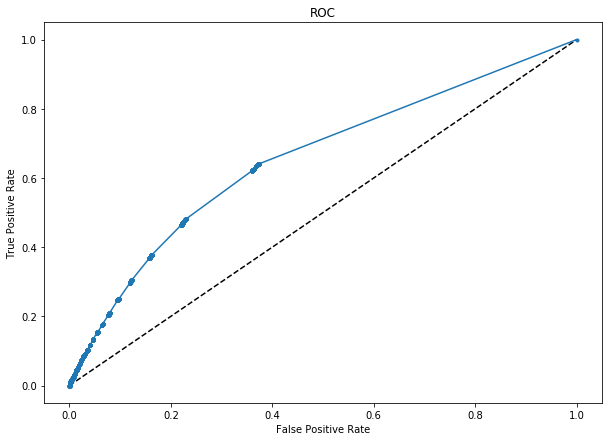

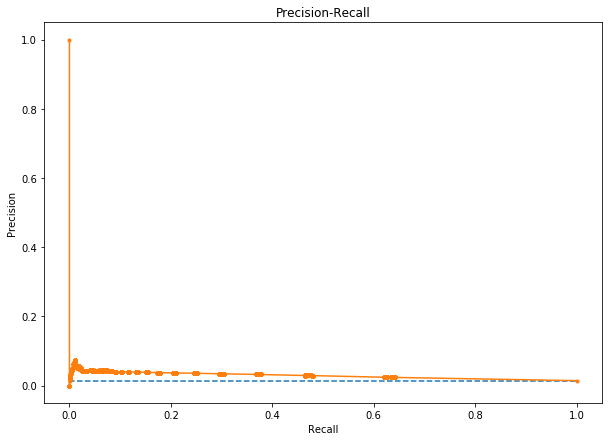

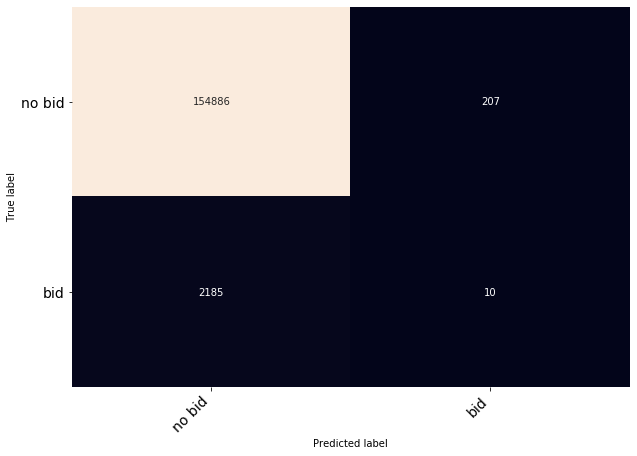

roc auc 0.6566741034077475
email_sent_day_of_week,0.14072114754277953
segment_1_booked_fare_class_encoded,0.13012995401036714
email_sent_days_before_departure,0.08305524169540064
segment_1_origin_destination_encoded,0.08205734159363919
segment_2_booked_fare_class_encoded,0.07880023893698163
email_sent_hour,0.07201690737768977
passenger_count,0.05629048468622793
segment_1_destination_encoded,0.055601396707686865
segment_2_origin_destination_encoded,0.0477573757970605
segment_1_origination_encoded,0.046689188852232374
segment_2_destination_encoded,0.03405405047439405
point_of_sale_encoded,0.03133783235281918
segment_2_origination_encoded,0.026813788814379614
partner_id,0.017378768568432946
language_encoded,0.016614719250497897
segment_3_origin_destination_encoded,0.011219492598901466
segment_3_booked_fare_class_encoded,0.009641413460767977
segment_3_origination_encoded,0.009636062288921348
segment_2_upgrade_cabin_encoded,0.009171485884525252
segment_1_upgrade_cabin_encoded,0.008871729699

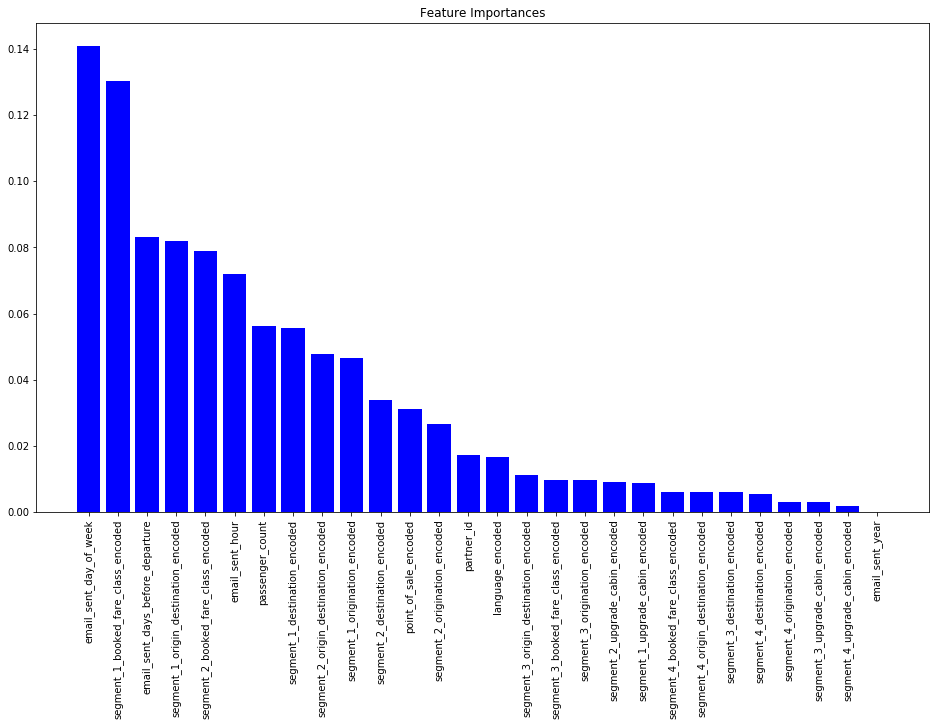

Running simulation on test set
157288 email sent
2195 actual number of offers
conversion ratio 0.013955292202838105
predicted_positive 217 with threshold 0.5
size of new test set 3774912
Row 0 raw_email_sent_hour 11 raw_proba 0.02 best_email_sent_hour 0 best_proba 0.03
Row 7864 raw_email_sent_hour 8 raw_proba 0.0 best_email_sent_hour 0 best_proba 0.02
Row 15728 raw_email_sent_hour 1 raw_proba 0.0 best_email_sent_hour 3 best_proba 0.0016666666666666666
Row 23592 raw_email_sent_hour 18 raw_proba 0.0 best_email_sent_hour 23 best_proba 0.04
Row 31456 raw_email_sent_hour 7 raw_proba 0.01 best_email_sent_hour 0 best_proba 0.05
Row 39320 raw_email_sent_hour 3 raw_proba 0.0 best_email_sent_hour 21 best_proba 0.15
Row 47184 raw_email_sent_hour 0 raw_proba 0.0 best_email_sent_hour 9 best_proba 0.12458333333333332
Row 55048 raw_email_sent_hour 2 raw_proba 0.0 best_email_sent_hour 1 best_proba 0.02
Row 62912 raw_email_sent_hour 22 raw_proba 0.01 best_email_sent_hour 21 best_proba 0.03
Row 70776 ra

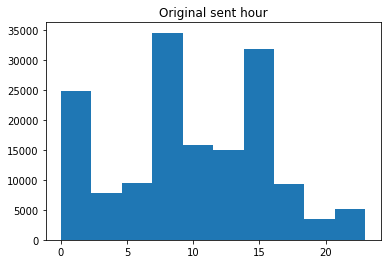

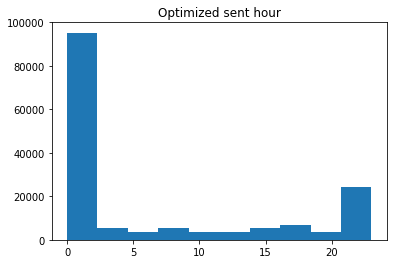

found  48 partners in the test set
partner_id 1 original_proba_for_partner 41.86238636363636 optimized proba 107.12959559884554
partner_id 4 original_proba_for_partner 37.15429761904762 optimized proba 163.5553968253978
partner_id 8 original_proba_for_partner 25.736 optimized proba 70.9702063492066
partner_id 9 original_proba_for_partner 43.64130303030303 optimized proba 139.6827698412696
partner_id 11 original_proba_for_partner 86.75266666666667 optimized proba 295.5553095238116
partner_id 12 original_proba_for_partner 59.26609523809524 optimized proba 185.88550000000112
partner_id 13 original_proba_for_partner 101.9196711322733 optimized proba 267.39365327268195
partner_id 18 original_proba_for_partner 6.52554761904762 optimized proba 51.576334054834
partner_id 20 original_proba_for_partner 0.2525 optimized proba 0.42166666666666663
partner_id 23 original_proba_for_partner 2.961666666666667 optimized proba 12.938361111111085
partner_id 24 original_proba_for_partner 4.517 optimized pr

In [21]:
train_and_evaluate(df,plot_learning_curves=False,limit=500_000, split_on_time=True, sim=True)

split on time
training on 1169306 rows...
testing on 537572 rows...
training is done!
precision 0.053554040895813046
recall 0.007194244604316547
f1 0.012684501845018452
support 7645


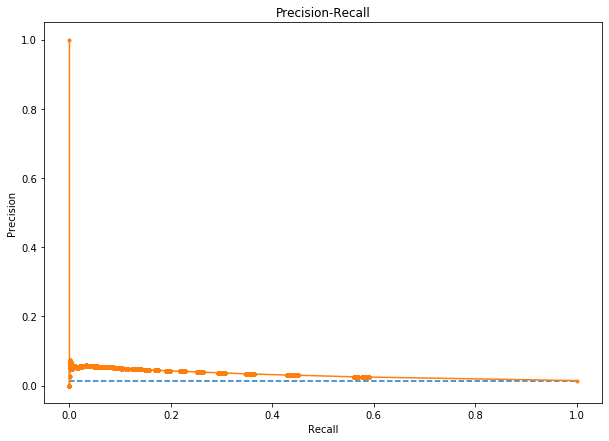

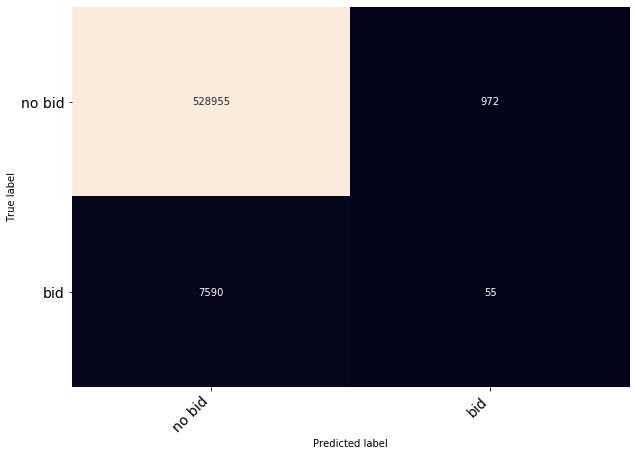

roc auc 0.6487452991893328
email_sent_day_of_week,0.15709991058464076
segment_1_booked_fare_class_encoded,0.1411396511672449
email_sent_days_before_departure,0.08863748051565948
segment_2_booked_fare_class_encoded,0.08427325143222493
segment_1_origin_destination_encoded,0.07210512083531954
email_sent_hour,0.07066314121240085
passenger_count,0.06081830703285405
segment_1_destination_encoded,0.04733076372465714
segment_2_origin_destination_encoded,0.04336239218791671
segment_1_origination_encoded,0.039737047487797265
segment_2_destination_encoded,0.03154781777438728
point_of_sale_encoded,0.031173071153253983
segment_2_origination_encoded,0.022366902775169867
language_encoded,0.01474031589345971
partner_id,0.014488489131311668
segment_3_origin_destination_encoded,0.011761821369918078
segment_3_booked_fare_class_encoded,0.010894855520653867
segment_3_origination_encoded,0.009619780331548504
segment_1_upgrade_cabin_encoded,0.007975700135663533
segment_2_upgrade_cabin_encoded,0.0077967931673

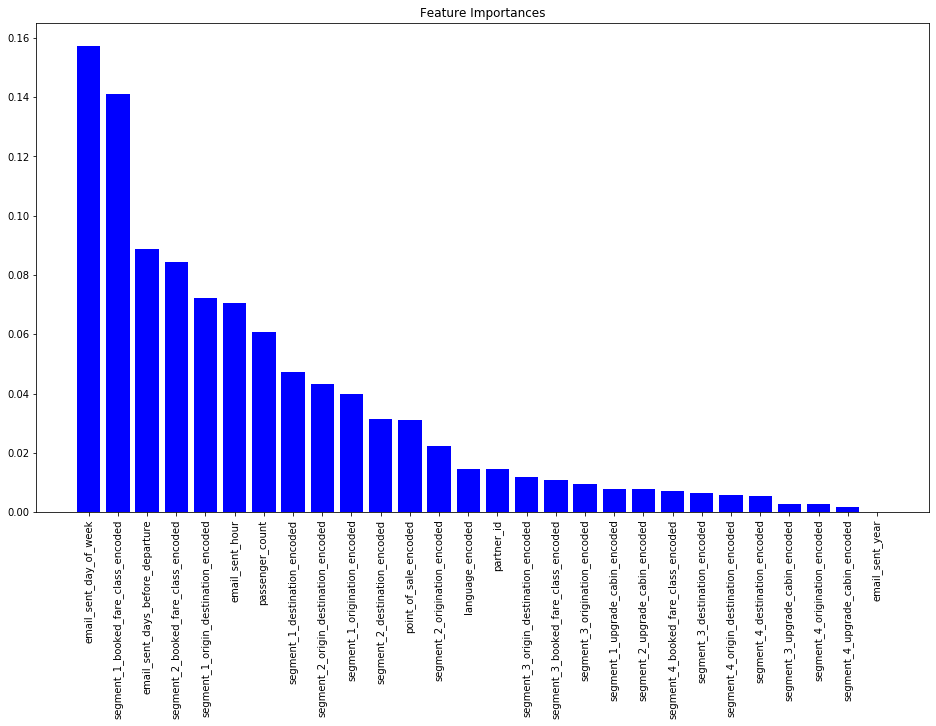

In [22]:
train_and_evaluate(df,plot_learning_curves=False,limit=None, split_on_time=True, by_partner=False)